In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# Function to read and process the log file
def process_log_file(file_path):
    with open(file_path, 'r') as file:
        log_data = file.read()
    
    # Use regex to extract the values
    pattern = re.compile(r"iteration\s+(\d+)/\s+\d+ \| consumed samples:\s+(\d+) \| consumed tokens:\s+(\d+) \| elapsed time per iteration \(ms\):\s+([\d.]+) \| learning rate:\s+([\d.E+-]+) \| global batch size:\s+(\d+) \| lm loss:\s+([\d.E+-]+) \| loss scale:\s+([\d.E+-]+) \| actual seqlen:\s+(\d+) \| number of skipped iterations:\s+(\d+) \| number of nan iterations:\s+(\d+) \| samples per second:\s+([\d.]+) \| tokens per gpu per second \(tgs\):\s+([\d.]+) \| TFLOPs:\s+([\d.]+)")

    # List to store extracted data
    data = []

    # Extract data row by row
    for match in pattern.findall(log_data):
        data.append([int(match[0]), int(match[1]), int(match[2]), float(match[3]), float(match[4]), int(match[5]), 
                     float(match[6]), float(match[7]), int(match[8]), int(match[9]), int(match[10]), 
                     float(match[11]), float(match[12]), float(match[13])])

    # Create a DataFrame
    columns = ["iteration", "consumed samples", "consumed tokens", "elapsed time per iteration (ms)", "learning rate",
               "global batch size", "lm loss", "loss scale", "actual seqlen", "number of skipped iterations", 
               "number of nan iterations", "samples per second", "tokens per gpu per second (tgs)", "TFLOPs"]

    df = pd.DataFrame(data, columns=columns)
    df["total elapsed time"] = df["elapsed time per iteration (ms)"].cumsum() / 1000
    return df

# Function to plot the smoothed loss with reduced line thickness
def plot_smoothed_loss(df, smoothing_factor=0.9):
    # Apply exponential moving average (EMA) to smooth the loss curve
    smoothed_loss = df["lm loss"].ewm(alpha=(1 - smoothing_factor)).mean()
    
    # Plot the original and smoothed loss curves
    # plt.plot(df["total elapsed time"], df["lm loss"], label="Original Loss", linestyle="--", alpha=0.5, linewidth=1)
    plt.plot(df["total elapsed time"], smoothed_loss, label="Smoothed Loss", linestyle="--", color="blue", linewidth=1.5)
    
    plt.title(f"GPT-2 Synchronous Training with DeepSpeed (2 GPUs)")
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("LM Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

def calculate_stats(df):
    # Calculate statistics
    avg_elapsed_time = df["elapsed time per iteration (ms)"].mean()
    avg_samples_per_sec = df["samples per second"].mean()
    avg_tokens_per_gpu_sec = df["tokens per gpu per second (tgs)"].mean()
    avg_tflops = df["TFLOPs"].mean()

    # Display calculated statistics
    calculated_stats = {
        "Average Elapsed Time (ms)": avg_elapsed_time,
        "Average Samples Per Second": avg_samples_per_sec,
        "Average Tokens per GPU per Second (TGS)": avg_tokens_per_gpu_sec,
        "Average TFLOPs": avg_tflops
    }
    return calculated_stats


# Function to plot the smoothed loss with reduced line thickness
def plot_losses_100(dfs, title = "Effect of Model Sharding on Training Speed (100 Iters)", pdf=False, smoothing_factor=0.9):
    for df, label in dfs:
        # Apply exponential moving average (EMA) to smooth the loss curve
        smoothed_loss = df["lm loss"].ewm(alpha=(1 - smoothing_factor)).mean()
        plt.plot(df["total elapsed time"], smoothed_loss, label=label, linestyle="--", linewidth=1.5)
    
    plt.title(title)
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("LM Loss")
    plt.grid(True)
    plt.legend()
    # plt.show()
    if pdf:
        os.makedirs('./plots', exist_ok=True)
        plt.savefig("./plots/model_sharding_100_iters.pdf")
    
def parse_DP(file_path):

    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # List to hold parsed data
    parsed_data = []

    # Define a regex pattern to capture all fields from each iteration log
    pattern = re.compile(r"iteration\s+(\d+)/\s+(\d+)\s+\|\s+"
                        r"consumed samples:\s+(\d+)\s+\|\s+"
                        r"consumed tokens:\s+(\d+)\s+\|\s+"
                        r"elapsed time per iteration \(ms\):\s+([\d\.]+)\s+\|\s+"
                        r"learning rate:\s+([\d\.E\+\-]+)\s+\|\s+"
                        r"global batch size:\s+(\d+)\s+\|\s+"
                        r"lm loss:\s+([\d\.E\+\-]+)\s+\|\s+"
                        r"loss scale:\s+([\d\.]+)\s+\|\s+"
                        r"grad norm:\s+([\d\.]+)\s+\|\s+"
                        r"num zeros:\s+([\d\.]+)\s+\|\s+"
                        r"actual seqlen:\s+(\d+)\s+\|\s+"
                        r"number of skipped iterations:\s+(\d+)\s+\|\s+"
                        r"number of nan iterations:\s+(\d+)\s+\|\s+"
                        r"samples per second:\s+([\d\.]+)\s+\|\s+"
                        r"tokens per gpu per second \(tgs\):\s+([\d\.]+)\s+\|\s+"
                        r"TFLOPs:\s+([\d\.]+)\s+\|")


    # Process each line and extract the relevant fields using the same regex pattern
    for line in lines:
        match = pattern.search(line)
        if match:
            parsed_data.append([float(g) if i != 0 else int(g) for i, g in enumerate(match.groups())])
            

    columns = ["iteration","total_iterations", "consumed samples", "consumed tokens", "elapsed time per iteration (ms)", "learning rate",
                "global batch size", "lm loss", "loss scale", "grad_norm", "num_zeros", "actual seqlen", "number of skipped iterations", 
                "number of nan iterations", "samples per second", "tokens per gpu per second (tgs)", "TFLOPs"]

    # Create the dataframe
    df = pd.DataFrame(parsed_data, columns=columns)
    df["total elapsed time"] = df["elapsed time per iteration (ms)"].cumsum() / 1000
    return df

In [3]:
df_DP = process_log_file('./data/dp_training_run.log')
df_DP

,iteration,consumed samples,consumed tokens,elapsed time per iteration (ms),learning rate,global batch size,lm loss,loss scale,actual seqlen,number of skipped iterations,number of nan iterations,samples per second,tokens per gpu per second (tgs),TFLOPs,total elapsed time
0,1,1024,262144,83781.7,0.000060,1024,10.826870,1.0,256,0,0,12.222,1564.447,1.35,83.7817
1,2,2048,524288,100798.4,0.000060,1024,10.649660,1.0,256,0,0,10.159,1300.339,1.12,184.5801
2,3,3072,786432,82609.8,0.000060,1024,10.582610,1.0,256,0,0,12.396,1586.639,1.37,267.1899
3,4,4096,1048576,82703.2,0.000060,1024,10.538280,1.0,256,0,0,12.382,1584.847,1.36,349.8931
4,5,5120,1310720,82572.5,0.000060,1024,10.517830,1.0,256,0,0,12.401,1587.357,1.37,432.4656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,98304,25165824,82312.5,0.000059,1024,8.113610,1.0,256,0,0,12.440,1592.370,1.37,7912.4095
96,97,99328,25427968,82169.8,0.000059,1024,8.084414,1.0,256,0,0,12.462,1595.137,1.37,7994.5793
97,98,100352,25690112,82549.4,0.000059,1024,8.064236,1.0,256,0,0,12.405,1587.801,1.37,8077.1287
98,99,101376,25952256,82320.9,0.000059,1024,8.058146,1.0,256,0,0,12.439,1592.208,1.37,8159.4496


In [4]:
df_TP = parse_DP('./data/tp_training_run.log')
df_TP

,iteration,total_iterations,consumed samples,consumed tokens,elapsed time per iteration (ms),learning rate,global batch size,lm loss,loss scale,grad_norm,num_zeros,actual seqlen,number of skipped iterations,number of nan iterations,samples per second,tokens per gpu per second (tgs),TFLOPs,total elapsed time
0,1,100.0,1024.0,262144.0,118305.5,0.000060,1024.0,10.836380,1.0,8.072,0.0,256.0,0.0,0.0,8.656,1107.911,0.95,118.3055
1,2,100.0,2048.0,524288.0,166280.1,0.000060,1024.0,10.655110,1.0,4.052,0.0,256.0,0.0,0.0,6.158,788.260,0.68,284.5856
2,3,100.0,3072.0,786432.0,117474.7,0.000060,1024.0,10.585400,1.0,1.949,0.0,256.0,0.0,0.0,8.717,1115.747,0.96,402.0603
3,4,100.0,4096.0,1048576.0,118006.2,0.000060,1024.0,10.538970,1.0,1.951,0.0,256.0,0.0,0.0,8.678,1110.721,0.96,520.0665
4,5,100.0,5120.0,1310720.0,118041.5,0.000060,1024.0,11.118500,1.0,2.302,0.0,256.0,0.0,0.0,8.675,1110.389,0.96,638.1080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,100.0,98304.0,25165824.0,116939.8,0.000006,1024.0,8.968536,1.0,1.816,0.0,256.0,0.0,0.0,8.757,1120.850,0.96,11297.5388
96,97,100.0,99328.0,25427968.0,117069.4,0.000006,1024.0,8.958909,1.0,1.816,0.0,256.0,0.0,0.0,8.747,1119.609,0.96,11414.6082
97,98,100.0,100352.0,25690112.0,117171.5,0.000006,1024.0,8.959976,1.0,1.904,0.0,256.0,0.0,0.0,8.739,1118.634,0.96,11531.7797
98,99,100.0,101376.0,25952256.0,117172.4,0.000006,1024.0,8.952519,1.0,1.827,0.0,256.0,0.0,0.0,8.739,1118.625,0.96,11648.9521


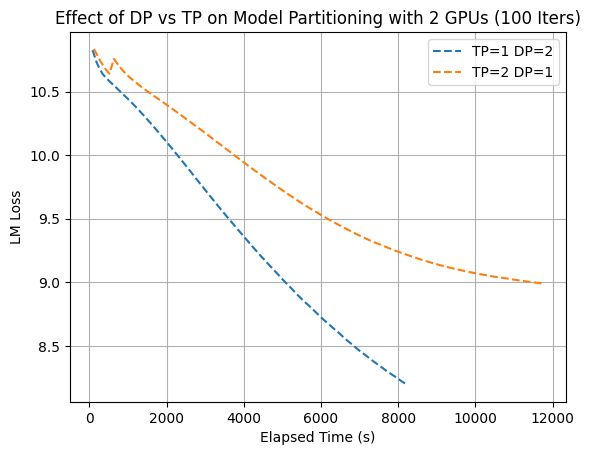

In [5]:
dfs_2 =  [(df_DP, "TP=1 DP=2"), (df_TP, "TP=2 DP=1")]
plot_losses_100(dfs_2, title="Effect of DP vs TP on Model Partitioning with 2 GPUs (100 Iters)", pdf=True)

/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_29093/1169502088.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


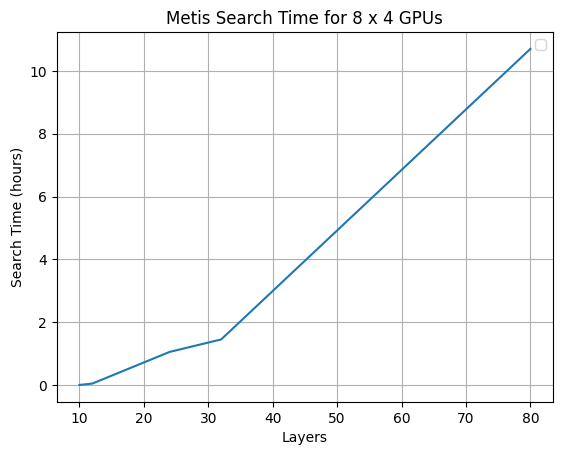

In [6]:
x = [10, 12, 24, 32, 80]
y_seconds = [10.597, 165.5598, 3794.89, 5225, 38527]
y_hours = [i/3600 for i in y_seconds]
plt.plot(x, y_hours)
plt.title("Metis Search Time for 8 x 4 GPUs")
plt.xlabel("Layers")
plt.ylabel("Search Time (hours)")
plt.grid(True)
plt.legend()
plt.savefig("./plots/metis_search_time.pdf")
# plt.show()